<a href="https://colab.research.google.com/github/Bo-kyoung/practices/blob/main/VGG16_CIFAR10_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from torchvision import models
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)
  print("cuda")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
from torchvision import models
from torchsummary import summary
from torch.utils.data import TensorDataset

cuda


In [3]:
learning_rate = 0.01
training_epochs = 74
batch_size = 256

In [4]:
CIFAR10_train = dsets.CIFAR10(root='data/',train = True, download=True, transform=transform)
CIFAR10_test = dsets.CIFAR10(root='data/', train=False, download = True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [5]:
length_train = len(CIFAR10_train)
train_set, valid_set = torch.utils.data.random_split(CIFAR10_train, [int(length_train *0.8) , int(length_train *0.2)])


In [6]:
train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True,drop_last = True)
test_loader = DataLoader(dataset = CIFAR10_test, batch_size = batch_size, shuffle = False,drop_last = True)
valid_loader = DataLoader(dataset = valid_set, batch_size = batch_size, shuffle = False,drop_last = True)

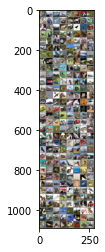

  cat   ship   ship  plane


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
%matplotlib inline
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
  img = img/2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

dataiter = iter(test_loader)
images,labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

print('  '.join('%5s' % classes[labels[j]] for j in range(4)))


In [8]:
class VGG16(nn.Module):
  def __init__(self, init_weights = True):
    super(VGG16, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =128,out_channels = 128,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =256,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =256,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels =256,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
        )
    if init_weights: 
      self._initialize_weights()
    
    self.classfier = nn.Sequential(
    nn.Linear(4*4*512,4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.BatchNorm1d(4096),
    nn.Linear(4096,4096),
    nn.ReLU(True),
    nn.Dropout(0.5), 
    nn.Linear(4096,10)
    )
  
  


  def forward(self, x):
    out = self.conv(x)
    out = out.view(out.size(0),-1)
    out = self.classfier(out)
    return out
#https://blog.naver.com/PostView.naver?blogId=mmmy2513&logNo=222300615187
#https://blogofth-lee.tistory.com/265?category=872318
  def _initialize_weights(self): 
    for m in self.modules(): 
      if isinstance(m, nn.Conv2d): 
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
        if m.bias is not None: 
          nn.init.constant_(m.bias, 0) 
      elif isinstance(m, nn.BatchNorm2d): 
        nn.init.constant_(m.weight, 1) 
        nn.init.constant_(m.bias, 0) 
      elif isinstance(m, nn.Linear): 
        nn.init.normal_(m.weight,0,0.01) 
        nn.init.constant_(m.bias, 0)




In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, loss_history):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  train_loss, correct = 0, 0
  for batch, (x,y) in enumerate(dataloader):
    x = x.to(device)
    y = y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss = loss.item()/num_batches
    
    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(x)
      print(f"loss {loss:>7f} [{current:>5d}/{size:>5d}]")
  loss_history.append(train_loss)
      
  

def test_loop(dataloader, model, loss_fn, loss_history, acc_history):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for x, y in dataloader:
      x = x.to(device)
      y = y.to(device)
      pred = model(x)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  loss_history.append(test_loss)
  acc_history.append(100*correct)
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
model = VGG16().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(),lr = 0.03,momentum = 0.9)
#lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma =0.9)

summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

Epoch 1
-------------------------------
loss 2.310492 [    0/40000]
loss 1.901835 [25600/40000]

Test Data
Test Error: 
 Accuracy: 35.5%, Avg loss: 1.815735 

Validation Data
Test Error: 
 Accuracy: 34.5%, Avg loss: 1.839860 

Epoch 2
-------------------------------
loss 1.796399 [    0/40000]
loss 1.550238 [25600/40000]

Test Data
Test Error: 
 Accuracy: 44.6%, Avg loss: 1.532058 

Validation Data
Test Error: 
 Accuracy: 44.8%, Avg loss: 1.524671 

Epoch 3
-------------------------------
loss 1.515107 [    0/40000]
loss 1.307279 [25600/40000]

Test Data
Test Error: 
 Accuracy: 53.9%, Avg loss: 1.288207 

Validation Data
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.270802 

Epoch 4
-------------------------------
loss 1.291275 [    0/40000]
loss 1.383697 [25600/40000]

Test Data
Test Error: 
 Accuracy: 57.4%, Avg loss: 1.171688 

Validation Data
Test Error: 
 Accuracy: 57.5%, Avg loss: 1.165078 

Epoch 5
-------------------------------
loss 1.143266 [    0/40000]
loss 1.148668 [25600/400

<function matplotlib.pyplot.show>

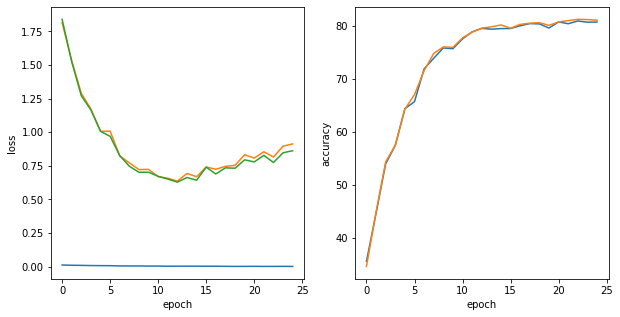

In [11]:
train_loss_history = []
test_loss_history = []
valid_loss_history = []
test_acc_history = []
valid_acc_history =[]
epochs = 25
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, train_loss_history)
    print("\nTest Data")
    test_loop(test_loader, model, loss_fn, test_loss_history,test_acc_history)
    print("Validation Data")
    test_loop(valid_loader, model, loss_fn, valid_loss_history,valid_acc_history)
print("Done!")


<function matplotlib.pyplot.show>

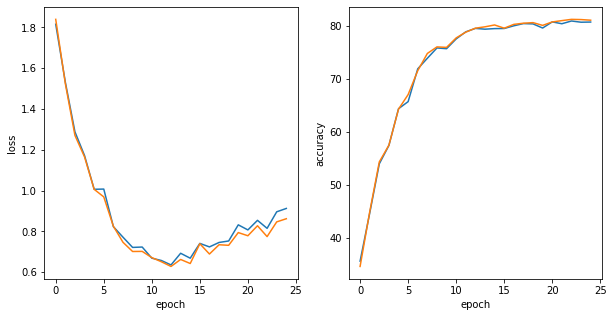

In [13]:
import matplotlib.pyplot as plt
loss_graph_1 = torch.as_tensor(train_loss_history,device='cpu')
loss_graph_2 = torch.as_tensor(test_loss_history,device='cpu')
loss_graph_3 = torch.as_tensor(valid_loss_history,device='cpu')
acc_1 = torch.as_tensor(test_acc_history,device='cpu')
acc_2 = torch.as_tensor(valid_acc_history,device='cpu')
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
#plt.plot(loss_graph_1)
plt.plot(loss_graph_2, label = "test")
plt.plot(loss_graph_3, label = "valid")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot(acc_1, label = "test")
plt.plot(acc_2, label = "valid")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show